# Data analysis du naufrage du Titanic

### Pré-processing des données

In [9]:
import numpy as np
import matplotlib as plt
import pandas as pd
import seaborn as sbs

In [169]:
data = pd.read_excel('titanic3.xls')
# On charge nos données dans une variable data

In [170]:
data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


In [171]:
data[data['age'].isnull()]['survived'].value_counts(normalize=True)

survived
0    0.722433
1    0.277567
Name: proportion, dtype: float64

In [172]:
def preprocessing(data):

    # Le fare est le prix par cabine. Il n'est pas assez représentatif du niveau de richesse. On va donc remplacer ça par un fare par personne.
    n = data.groupby('ticket')['ticket'].transform('count')
    data['fare'] = data['fare'] / n
    
    # On combine les features sibsp (siblings/spouse) et parch (parents/children) pour en faire une plus générale : fam_size (family size)
    data['fam_size'] = data['sibsp'] + data['parch']
    
    data = data.drop([
        'name', # Le nom n'a pas d'impact sur la survie ou non du passager
        'ticket', # Idem
        'cabin', # Peu de données, difficiles à encoder puisque certains passagers en ont plusieurs, d'autre une seule
        'boat', # boat est un data leakage puisque les personnes n'ayant pas été évacuées par bateau n'ont pas survécu
        'body', # body est aussi un data leakage puisque les personnes dont on a retrouvé le corps sont forcément mortes
        'home.dest', # Peu de données, formats hétérogènes,

        # On peut supprimer sibsp et parch maintenant qu'on a fam_size
        'sibsp',
        'parch'
        
    ], axis=1)
    
    data = data.dropna(axis=0) # On peut se permettre un dropna grâce aux résultats obtenus lors du test effectué
    # On retire tous les passagers dont on n'a pas toutes les infos pour éviter d'altérer la réalité

    return data

In [173]:
def encodage(data): # Encoder les données permet de les adapter au modèle
    
    data['sex'] = data['sex'].astype('category').cat.codes
    # On utilise astype qui nous permet de faire une catégorisation binaire
    
    data = pd.get_dummies(data, columns=['embarked'], prefix='embarked') 
    # On utilise get_dummies pour éviter d'établir un ordre arbitraire entre les ports d'embarquement (on ne peut pas utiliser astype puisque 3 categ)
    
    return data

In [174]:
from sklearn.model_selection import train_test_split

In [175]:
data = preprocessing(data)
data = encodage(data)

trainset, testset = train_test_split(data, test_size=0.2, random_state = 0)
# On sépare nos données en 2 sets : un pour entraîner le modèle, et un pour le tester

In [176]:
data

,pclass,survived,sex,age,fare,fam_size,embarked_C,embarked_Q,embarked_S
0,1,1,0,29.0000,211.337500,0,False,False,True
1,1,1,1,0.9167,25.258333,3,False,False,True
2,1,0,0,2.0000,25.258333,3,False,False,True
3,1,0,1,30.0000,25.258333,3,False,False,True
4,1,0,0,25.0000,25.258333,3,False,False,True
...,...,...,...,...,...,...,...,...,...
1301,3,0,1,45.5000,7.225000,0,True,False,False
1304,3,0,0,14.5000,7.227100,1,True,False,False
1306,3,0,1,26.5000,7.225000,0,True,False,False
1307,3,0,1,27.0000,7.225000,0,True,False,False


In [177]:
def split_ft(data):

    X = data.drop('survived', axis = 1) # X contient les features
    y = data['survived'] # y contient les target
    
    return X,y

In [178]:
X_train, y_train = split_ft(trainset)
X_test, y_test = split_ft(testset)

In [179]:
data.columns[5]

'fam_size'

### Modélisation

In [180]:
from sklearn.tree import DecisionTreeClassifier

In [181]:
model = DecisionTreeClassifier(random_state = 23) # Création de notre modèle

### Procédure d'évaluation

In [182]:
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, confusion_matrix, classification_report
# f1_score : proportion d'erreurs
# confusion_matrix : rapport entre faux-survivants et faux-naufragés
# classification_report : bilan de l'efficacité de notre modèle (accuracy etc)

from sklearn.model_selection import learning_curve
# learning_curve : permet de savoir si notre modèle est en over/underfitting dans le but d'adapter nos données

In [183]:
def evaluation(model):

    # Le modèle s'entraîne sur le set train
    model.fit(X_train, y_train)

    # On va afficher l'importance de chaque feature pour voir comment notre modèle s'en sert
    importances = model.feature_importances_
    for i in range (X_test.shape[1]):
        print(f'{X_test.columns[i]} : {importances[i]}')
    print(f'embarked total : {sum(importances[5 : 8])}')
    
    
    # il applique ce qu'il a appris lors du model.fit et prédit ainsi les résultats sur les passagers jamais vus lors de l'entraînement (X_test)
    ypred = model.predict(X_test)

    print(confusion_matrix(y_test, ypred))

    # classification_report calcule la précision, le rappel, le f1-score et le support pour chaque classe, à partir de y_test et des prédictions ypred
    print(classification_report(y_test, ypred))
    

    N, train_score, val_score = learning_curve(

        #la fonction learning_curve prend en arguments le modèle, et le train set
        model,
        X_train,
        y_train,

        # Validation croisée à 4 plis : le train set est découpé en 4 parties. 4 validations, avec chacune un pli de validation différent.
        cv = 4,

        # On utilise le score f1 comme métrique
        scoring = 'f1',

        # 10 tailles d’échantillons équidistantes (3e arg), comprises entre 10 % (1er arg) et 100 % (2e arg) de X_train
        train_sizes = np.linspace (0.1, 1, 10)
    )

    plt.figure(figsize = (6, 4))

    # L'idée en comparant le train score et le validation score est de déterminer si le modèle est en over/underfitting
    plt.plot(N, train_score.mean(axis=1), label = 'train score')
    plt.plot(N, val_score.mean(axis=1), label = 'validation score')
    
    plt.legend()

pclass : 0.09224463384978354
sex : 0.3013258659592385
age : 0.2630659596361533
fare : 0.23665958512180044
fam_size : 0.06874295076956805
embarked_C : 0.020981602753633005
embarked_Q : 0.005025114832418165
embarked_S : 0.011954287077404998
embarked total : 0.03796100466345617
[[110  16]
 [ 27  56]]
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       126
           1       0.78      0.67      0.72        83

    accuracy                           0.79       209
   macro avg       0.79      0.77      0.78       209
weighted avg       0.79      0.79      0.79       209



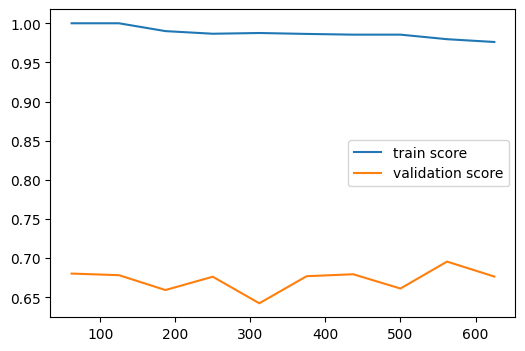

In [184]:
evaluation(model)

On remarque que notre modèle est en overfitting : son train score est relativement élevé alors que son validation score reste relativement faible.
Le modèle apprend correctement les règles spécifiques aux données d'entraînement, mais ne généralise pas. Il est donc inefficace sur des données qu'il n'a jamais vues dans le train set.
Il va donc falloir optimiser notre modèle, pour améliorer sa capacité de généralisation.

### Optimisation